# 07: PE Chunk Analysis

Analyze the first batch chunk from the PE generation run to verify data quality while the remaining 23 chunks complete overnight.

In [21]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

sys.path.insert(0, str(Path("..").resolve()))

plt.rcParams.update({
    "figure.dpi": 150,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.alpha": 0.3,
    "font.size": 9,
})

REAL_COLOR = "#4878CF"
SYNTH_COLOR = "#E24A33"

REPORTING = Path("../data/reporting")
BATCH_DIR = Path("../data/batch_jobs")

wide = pd.read_parquet(REPORTING / "wide_training_table.parquet")

chunk_files = sorted(BATCH_DIR.glob("batch_random_chunk*.parquet"))
chunks = [pd.read_parquet(f) for f in chunk_files]
chunk = pd.concat(chunks, ignore_index=True)

display(Markdown(
    f"Real wide table: {len(wide):,} rows x {len(wide.columns)} cols\n\n"
    f"PE chunks found: {len(chunk_files)} ({', '.join(f.stem.replace('batch_random_', '') for f in chunk_files)})\n\n"
    f"Merged synthetic records: {len(chunk):,} rows x {len(chunk.columns)} cols"
))

Real wide table: 1,000,000 rows x 69 cols

PE chunks found: 10 (chunk0, chunk1, chunk2, chunk3, chunk4, chunk5, chunk6, chunk7, chunk8, chunk9)

Merged synthetic records: 79,014 rows x 68 cols

---
## Categorical distributions

Compare the top-k value frequencies for each categorical column.

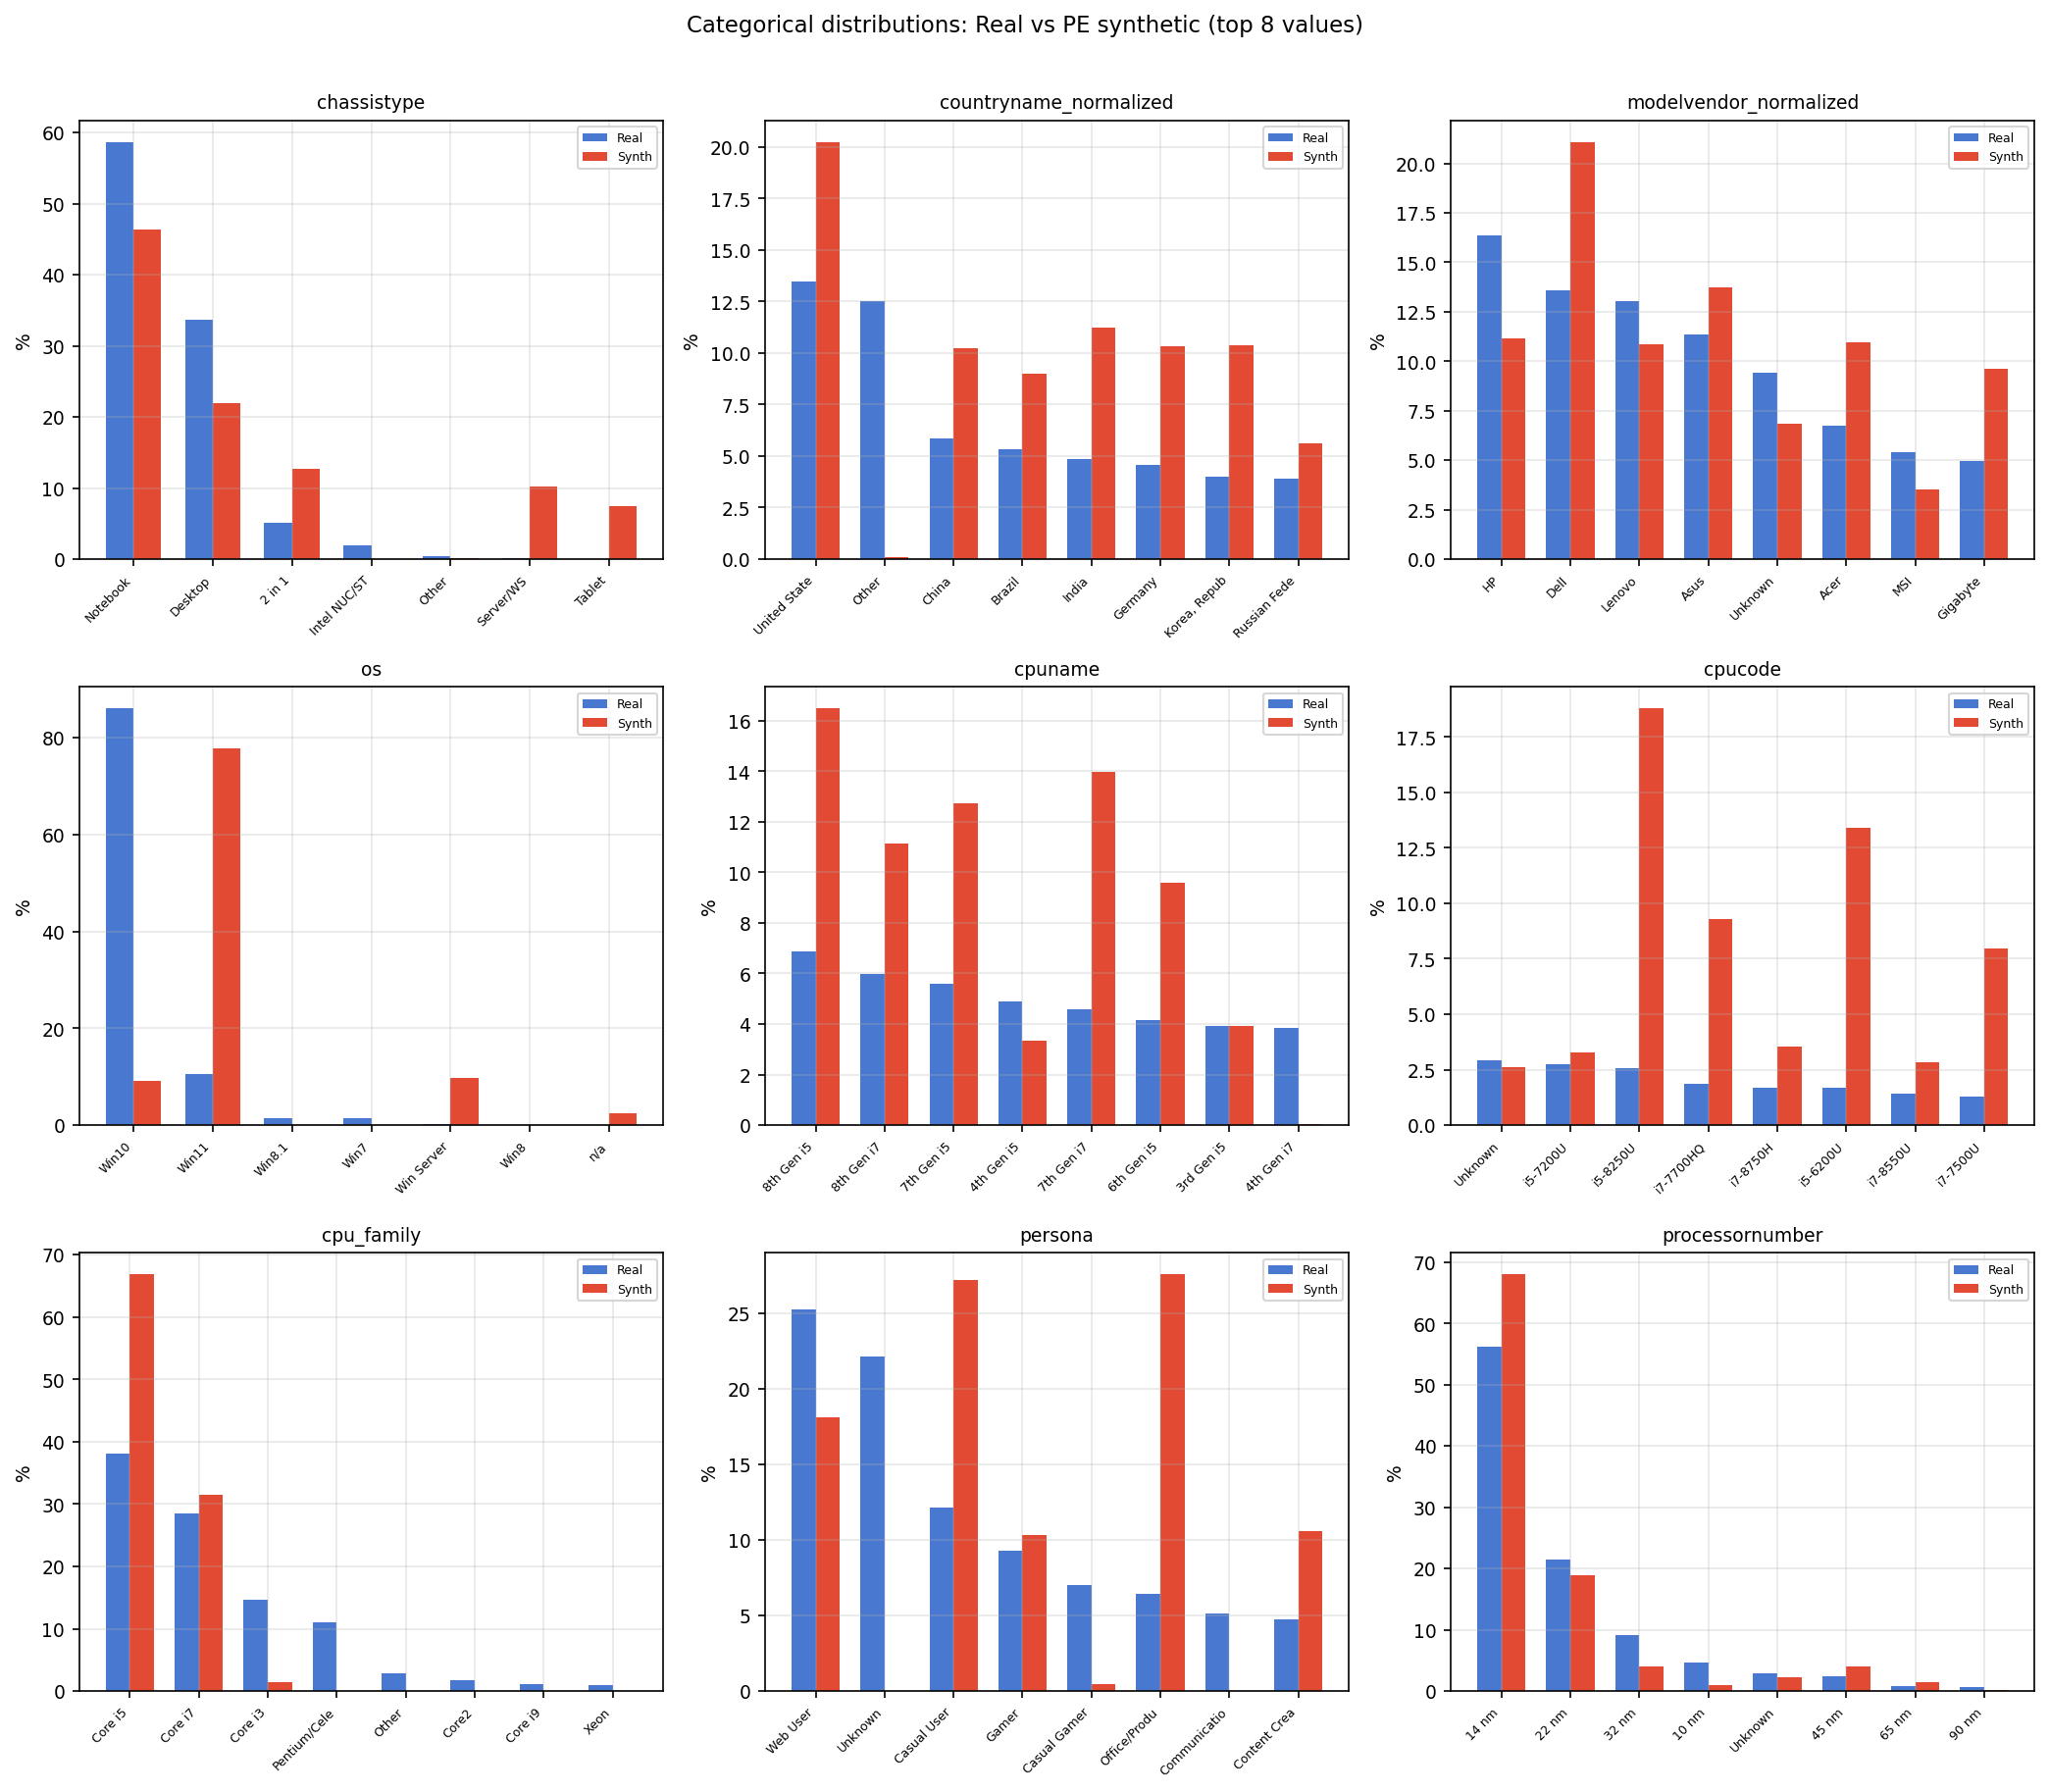

### chassistype

,real_pct,synth_pct
chassistype,,
2 in 1,5.1,12.7
3 in 1,0.0,0.1
Desktop,33.7,22.0
Intel NUC/STK,2.0,0.0
Laptop,0.0,0.4
Not Applicable,0.0,0.0
Notebook,58.7,46.4
Other,0.4,0.2
Server/WS,0.2,10.2


### countryname_normalized

,real_pct,synth_pct
countryname_normalized,,
Brazil,5.3,9.0
China,5.8,10.3
Germany,4.6,10.4
India,4.9,11.2
Japan,3.1,10.7
"Korea, Republic of",4.0,10.4
Other,12.5,0.0
Russia,0.0,1.8
Russian Federation,3.9,5.6


### modelvendor_normalized

,real_pct,synth_pct
modelvendor_normalized,,
ASUS,0.0,2.3
Acer,6.7,11.0
Asus,11.3,13.7
Dell,13.6,21.1
Gigabyte,5.0,9.6
HP,16.4,11.1
Intel,2.2,9.0
Lenovo,13.1,10.8
MSI,5.4,3.5


### os

,real_pct,synth_pct
os,,
Win Server,0.3,9.7
Win10,86.2,9.2
Win11,10.4,77.9
Win7,1.5,0.0
Win8,0.1,0.0
Win8.1,1.5,0.1
WinServer,0.0,0.7
WinSrv,0.0,0.0
Win_Server,0.0,0.0


### cpuname

,real_pct,synth_pct
cpuname,,
10th Gen i5,3.5,22.2
3rd Gen i5,3.9,3.9
4th Gen i5,4.9,3.3
4th Gen i7,3.8,0.0
6th Gen i5,4.2,9.6
6th Gen i7,3.6,5.9
7th Gen i5,5.6,12.7
7th Gen i7,4.6,14.0
8th Gen i5,6.9,16.5


### cpucode

,real_pct,synth_pct
cpucode,,
Unknown,2.9,0.0
i5-6200U,1.7,13.4
i5-7200U,2.7,3.3
i5-7500U,0.0,5.9
i5-8250U,2.6,18.8
i5-8265U,1.3,18.4
i7-6700HQ,1.3,7.5
i7-7500U,1.3,8.0
i7-7700HQ,1.9,9.3


### cpu_family

,real_pct,synth_pct
cpu_family,,
Atom,0.6,0.0
Core M,0.4,0.0
Core i3,14.7,1.5
Core i5,38.1,66.9
Core i7,28.4,31.5
Core i9,1.1,0.0
Core2,1.7,0.0
Other,2.9,0.0
Pentium/Celeron,11.1,0.0


### persona

,real_pct,synth_pct
persona,,
Casual Gamer,7.0,0.4
Casual User,12.1,27.2
Communication,5.1,0.0
Content Creator/IT,4.8,10.6
Entertainment,3.0,4.9
Gamer,9.3,10.3
Gaming,0.0,0.1
Office/Productivity,6.4,27.6
Unknown,22.1,0.0


### processornumber

,real_pct,synth_pct
processornumber,,
10 nm,4.7,0.9
14,0.5,0.1
14 nm,56.2,68.1
22 nm,21.5,18.8
32 nm,9.2,4.0
45 nm,2.4,4.1
46 nm,0.0,0.0
65 nm,0.8,1.5
90 nm,0.7,0.1


In [22]:
from src.pe.distance import CAT_COLS

fig, axes = plt.subplots(3, 3, figsize=(14, 12))
axes = axes.flatten()

for idx, c in enumerate(CAT_COLS):
    if c not in chunk.columns:
        continue
    ax = axes[idx]
    real_dist = wide[c].value_counts(normalize=True).head(8)
    synth_dist = chunk[c].value_counts(normalize=True)

    all_labels = real_dist.index.tolist()
    real_vals = [real_dist.get(l, 0) * 100 for l in all_labels]
    synth_vals = [synth_dist.get(l, 0) * 100 for l in all_labels]

    x = np.arange(len(all_labels))
    w = 0.35
    ax.bar(x - w / 2, real_vals, w, color=REAL_COLOR, label="Real")
    ax.bar(x + w / 2, synth_vals, w, color=SYNTH_COLOR, label="Synth")
    ax.set_xticks(x)
    ax.set_xticklabels([str(l)[:12] for l in all_labels], rotation=45, ha="right", fontsize=6)
    ax.set_ylabel("%")
    ax.set_title(c, fontsize=9)
    ax.legend(fontsize=6)

plt.suptitle("Categorical distributions: Real vs PE synthetic (top 8 values)", fontsize=11, y=1.01)
plt.tight_layout()
plt.show()

for c in CAT_COLS:
    if c not in chunk.columns:
        continue
    real_dist = wide[c].value_counts(normalize=True).head(10)
    synth_dist = chunk[c].value_counts(normalize=True).head(10)
    merged = pd.DataFrame({
        "real_pct": (real_dist * 100).round(1),
        "synth_pct": (synth_dist * 100).round(1),
    }).fillna(0)
    display(Markdown(f"### {c}"))
    display(merged)

---
## Categorical overlap

What fraction of synthetic categorical values actually exist in the real data?

In [23]:
overlap_rows = []
for c in CAT_COLS:
    if c not in chunk.columns:
        continue
    real_vals = set(wide[c].unique())
    synth_vals = set(chunk[c].unique())
    synth_in_real = chunk[c].isin(real_vals).mean() * 100
    novel = sorted(synth_vals - real_vals)[:5]
    overlap_rows.append({
        "column": c,
        "real_unique": len(real_vals),
        "synth_unique": len(synth_vals),
        "synth_in_real_pct": round(synth_in_real, 1),
        "novel_values": novel,
    })

display(Markdown("Fraction of synthetic records with categorical values present in real data:"))
display(pd.DataFrame(overlap_rows))

Fraction of synthetic records with categorical values present in real data:

,column,real_unique,synth_unique,synth_in_real_pct,novel_values
0,chassistype,7,131,98.9,"[ 2 in 1, Desktop, Laptop, Notebook, Serve..."
1,countryname_normalized,51,48,98.1,"[ Brazil, China, Germany, India, Japan]"
2,modelvendor_normalized,48,53,97.5,"[ ASUS, Acer, Asus, Dell, HP]"
3,os,7,21,99.2,"[, Win11, Server, Wil7, Win reality]"
4,cpuname,116,39,100.0,"[, Xeon, (Unknown), -, 7th Gen i5 (Mobile)]"
5,cpucode,1798,169,90.7,"[, i5-6200U, _i5-10210U, i5- three, i5-...]"
6,cpu_family,10,7,100.0,[]
7,persona,11,89,99.7,"[ Casual User, Entertainment, Gamer, Office..."
8,processornumber,13,46,99.9,"[ RAM, Unknown, stable, 12 nm, 144 nm]"


---
## Sparsity patterns

The wide table is extremely sparse. Does the LLM respect the zero-inflation?

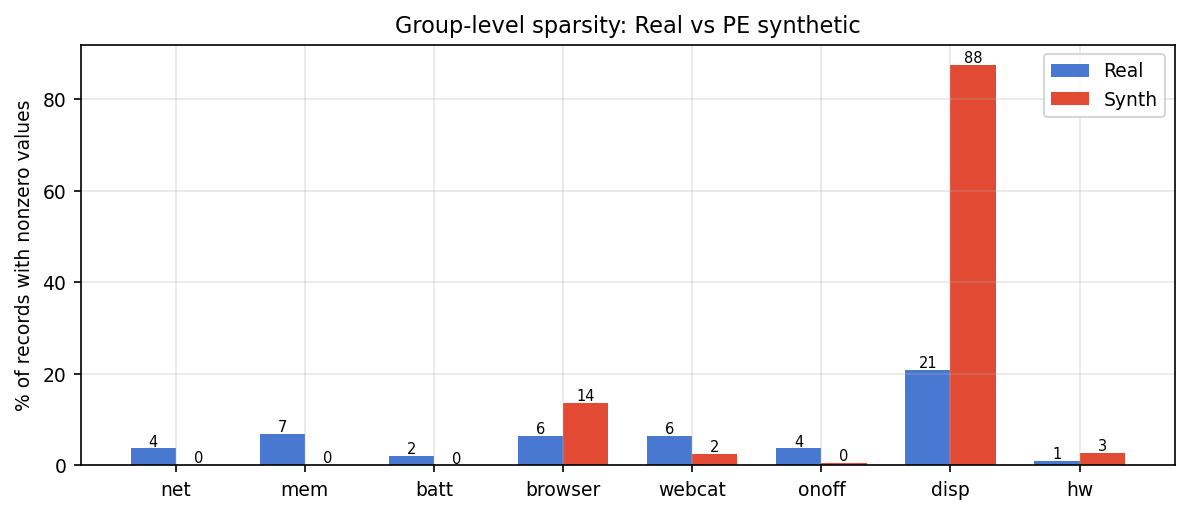

,group,columns,real_active_pct,synth_active_pct
0,net,3,3.7,0.1
1,mem,3,6.9,0.2
2,batt,2,2.0,0.0
3,browser,5,6.4,13.7
4,webcat,28,6.4,2.5
5,onoff,4,3.7,0.5
6,disp,3,20.9,87.5
7,hw,10,1.0,2.8


In [24]:
from src.pe.distance import NUMERIC_COLS

groups = {
    "net": [c for c in NUMERIC_COLS if c.startswith("net_")],
    "mem": [c for c in NUMERIC_COLS if c.startswith("mem_")],
    "batt": [c for c in NUMERIC_COLS if c.startswith("batt_")],
    "browser": [c for c in NUMERIC_COLS if c.startswith("web_")],
    "webcat": [c for c in NUMERIC_COLS if c.startswith("webcat_")],
    "onoff": [c for c in NUMERIC_COLS if c.startswith("onoff_")],
    "disp": [c for c in NUMERIC_COLS if c.startswith("disp_")],
    "hw": [c for c in NUMERIC_COLS if c in [
        "psys_rap_nrs", "psys_rap_avg", "pkg_c0_nrs", "pkg_c0_avg",
        "avg_freq_nrs", "avg_freq_avg", "temp_nrs", "temp_avg",
        "pkg_power_nrs", "pkg_power_avg",
    ]],
}

sparsity_rows = []
for gname, cols in groups.items():
    present_cols = [c for c in cols if c in wide.columns and c in chunk.columns]
    if not present_cols:
        continue
    real_active = (wide[present_cols].abs().sum(axis=1) > 0).mean() * 100
    synth_active = (chunk[present_cols].abs().sum(axis=1) > 0).mean() * 100
    sparsity_rows.append({
        "group": gname,
        "columns": len(present_cols),
        "real_active_pct": round(real_active, 1),
        "synth_active_pct": round(synth_active, 1),
    })

fig, ax = plt.subplots(figsize=(8, 3.5))
gnames = [r["group"] for r in sparsity_rows]
real_pcts = [r["real_active_pct"] for r in sparsity_rows]
synth_pcts = [r["synth_active_pct"] for r in sparsity_rows]
x = np.arange(len(gnames))
w = 0.35
ax.bar(x - w / 2, real_pcts, w, color=REAL_COLOR, label="Real")
ax.bar(x + w / 2, synth_pcts, w, color=SYNTH_COLOR, label="Synth")
ax.set_xticks(x)
ax.set_xticklabels(gnames)
ax.set_ylabel("% of records with nonzero values")
ax.set_title("Group-level sparsity: Real vs PE synthetic")
ax.legend()
for i, (r, s) in enumerate(zip(real_pcts, synth_pcts)):
    ax.text(i - w / 2, r + 0.5, f"{r:.0f}", ha="center", fontsize=7)
    ax.text(i + w / 2, s + 0.5, f"{s:.0f}", ha="center", fontsize=7)
plt.tight_layout()
plt.show()

display(pd.DataFrame(sparsity_rows))

---
## Per-column sparsity detail

In [25]:
col_sparsity = []
for c in NUMERIC_COLS:
    if c not in chunk.columns:
        continue
    real_nz = (wide[c] > 0).mean() * 100
    synth_nz = (chunk[c] > 0).mean() * 100
    col_sparsity.append({
        "column": c,
        "real_nonzero_pct": round(real_nz, 1),
        "synth_nonzero_pct": round(synth_nz, 1),
        "diff": round(synth_nz - real_nz, 1),
    })

sparsity_detail = pd.DataFrame(col_sparsity)
display(Markdown("Per-column nonzero percentage (real vs synthetic):"))
display(sparsity_detail)

Per-column nonzero percentage (real vs synthetic):

,column,real_nonzero_pct,synth_nonzero_pct,diff
0,ram,99.9,100.0,0.1
1,net_nrs,3.7,0.1,-3.6
2,net_received_bytes,3.7,0.1,-3.6
3,net_sent_bytes,3.7,0.1,-3.6
4,mem_nrs,6.9,0.1,-6.8
5,mem_avg_pct_used,6.9,0.1,-6.8
6,mem_sysinfo_ram,6.9,0.1,-6.8
7,batt_num_power_ons,2.0,0.0,-2.0
8,batt_duration_mins,2.0,0.0,-2.0
9,web_chrome_duration,5.3,13.3,8.0


---
## Numeric distributions (nonzero values only)

For columns where the LLM generated nonzero values, compare the distribution statistics.

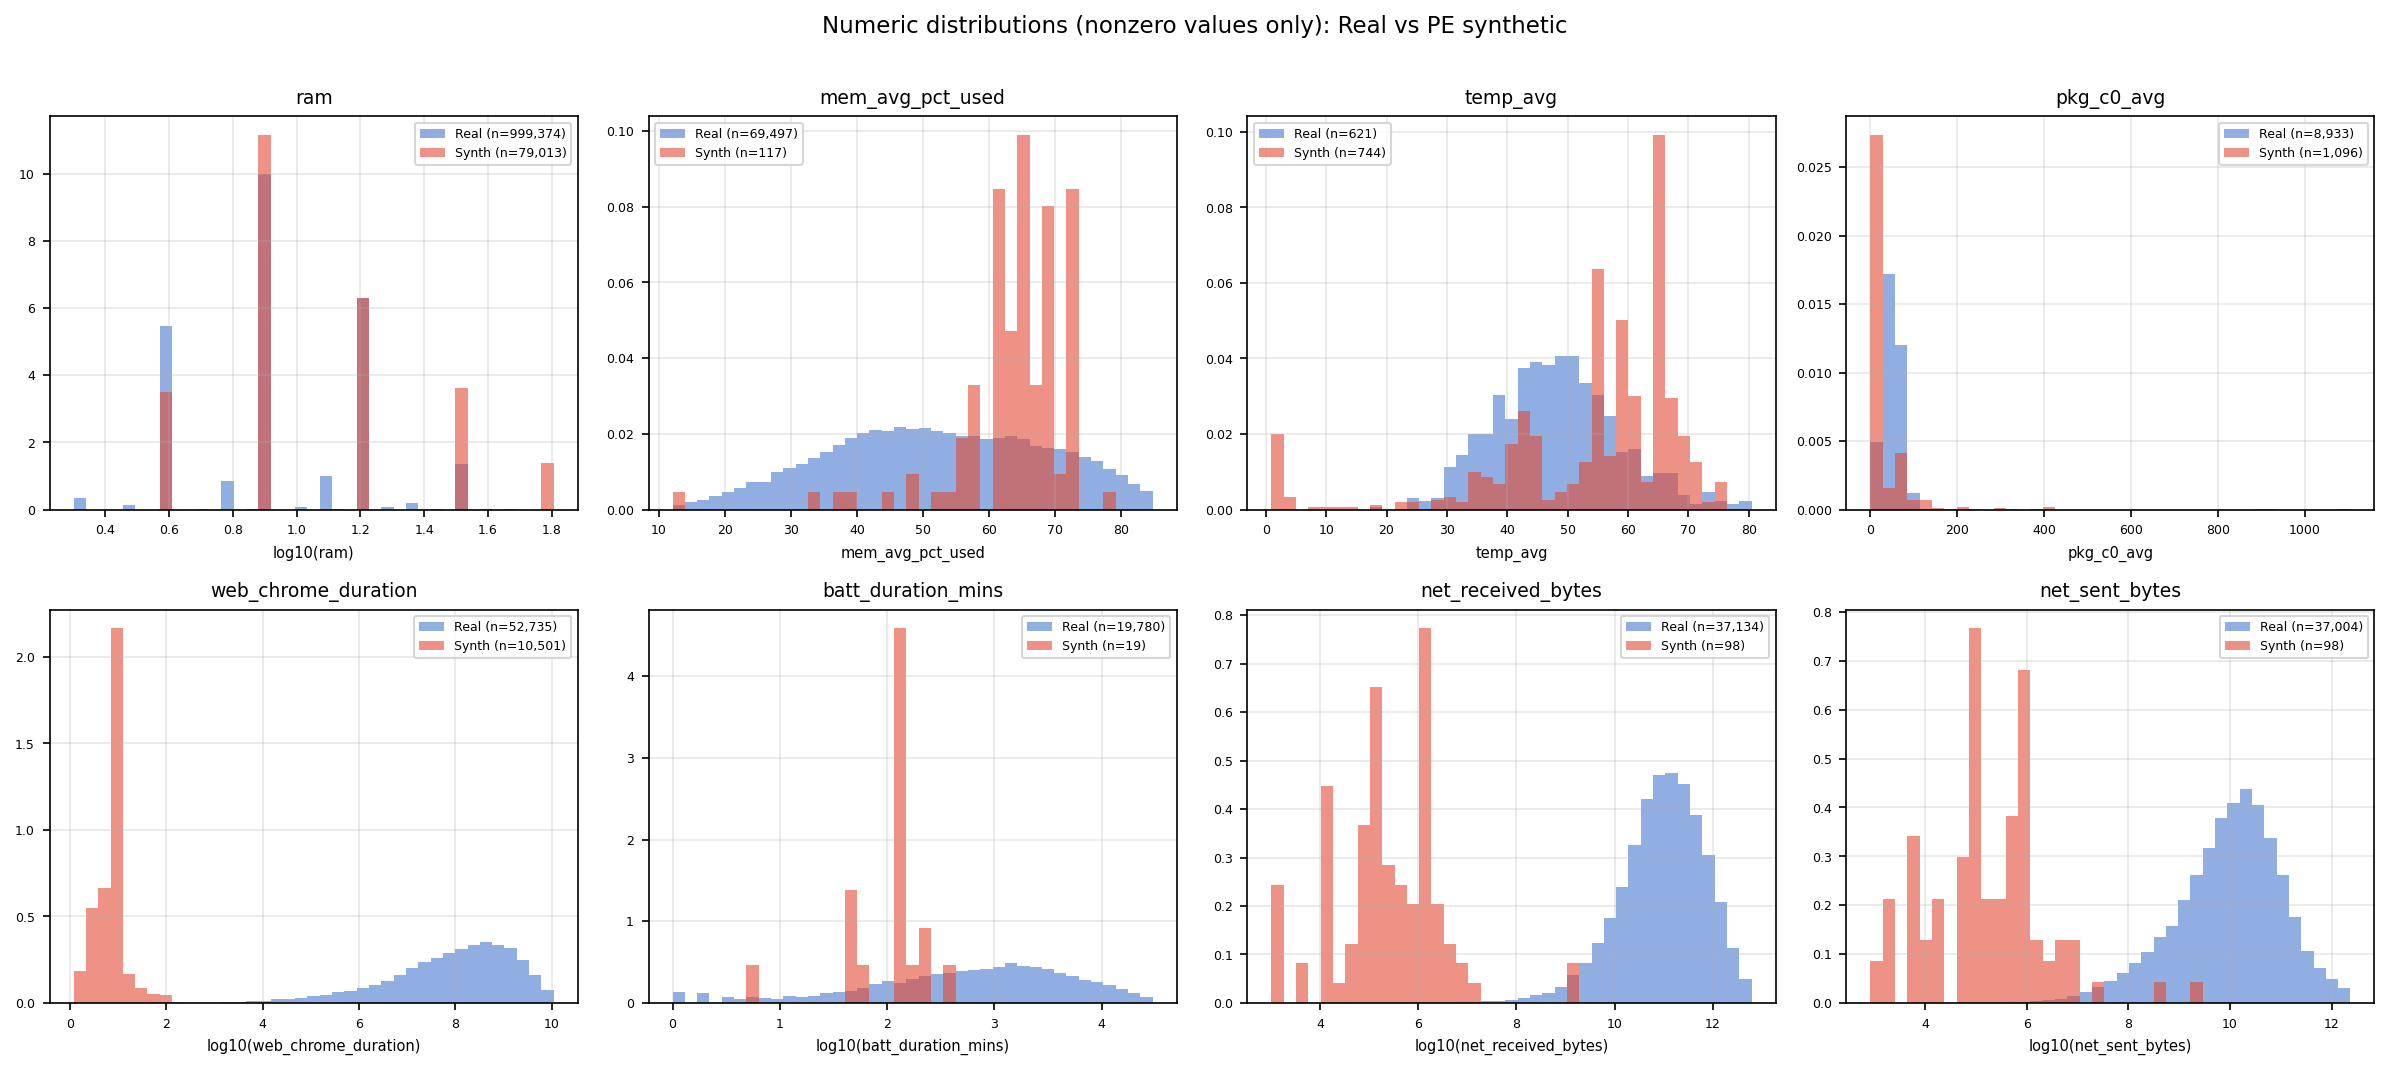

### ram (nonzero only: 999,374 real, 79,013 synth)

,real,synth
count,999374.00,79013.00
mean,15.36,15.72
std,4195.62,14.32
min,1.00,4.00
25%,6.00,8.00
50%,8.00,8.00
75%,16.00,16.00
max,4194304.00,128.00


### mem_avg_pct_used (nonzero only: 69,497 real, 117 synth)

,real,synth
count,69497.00,117.00
mean,52.35,62.95
std,16.68,11.07
min,2.56,12.00
25%,40.18,62.00
50%,52.18,65.00
75%,65.25,68.00
max,98.00,86.00


### temp_avg (nonzero only: 621 real, 744 synth)

,real,synth
count,621.00,744.00
mean,48.65,53.55
std,11.14,17.37
min,18.43,0.50
25%,41.40,45.00
50%,48.01,60.00
75%,54.76,65.00
max,98.05,98.00


### pkg_c0_avg (nonzero only: 8,933 real, 1,096 synth)

,real,synth
count,8933.00,1096.00
mean,50.49,49.26
std,19.37,274.15
min,1.68,0.04
25%,37.07,1.50
50%,50.42,2.50
75%,64.14,15.00
max,100.00,4800.00


### web_chrome_duration (nonzero only: 52,735 real, 10,501 synth)

,real,synth
count,5.273500e+04,10501.00
mean,9.265472e+08,11.60
std,2.442520e+09,19.19
min,5.300000e+01,0.20
25%,1.659316e+07,5.00
50%,1.428831e+08,12.40
75%,7.990055e+08,12.50
max,1.098596e+11,1200.00


### batt_duration_mins (nonzero only: 19,780 real, 19 synth)

,real,synth
count,19780.00,19.00
mean,2967.04,130.42
std,5854.54,90.94
min,1.00,6.00
25%,164.00,90.00
50%,811.50,120.00
75%,2971.25,135.00
max,82774.00,420.00


### net_received_bytes (nonzero only: 37,134 real, 98 synth)

,real,synth
count,3.713400e+04,9.800000e+01
mean,7.219171e+15,3.031801e+07
std,9.265684e+17,2.106290e+08
min,1.128000e+04,1.024000e+03
25%,2.888352e+10,1.024000e+05
50%,1.106272e+11,2.048000e+05
75%,3.920574e+11,1.200000e+06
max,1.386978e+20,1.800000e+09


### net_sent_bytes (nonzero only: 37,004 real, 98 synth)

,real,synth
count,3.700400e+04,9.800000e+01
mean,7.244095e+15,2.795279e+07
std,9.281947e+17,2.183026e+08
min,5.750000e+03,8.000000e+02
25%,2.356225e+09,5.120000e+04
50%,1.233305e+10,1.296170e+05
75%,4.938333e+10,8.000000e+05
max,1.386978e+20,2.100000e+09


In [26]:
key_numerics = ["ram", "mem_avg_pct_used", "temp_avg", "pkg_c0_avg",
                "web_chrome_duration", "batt_duration_mins", "net_received_bytes", "net_sent_bytes"]

plot_cols = [c for c in key_numerics if c in chunk.columns and c in wide.columns]
n = len(plot_cols)
fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()

for idx, c in enumerate(plot_cols):
    ax = axes[idx]
    real_nz = wide.loc[wide[c] > 0, c]
    synth_nz = chunk.loc[chunk[c] > 0, c]

    if len(synth_nz) == 0:
        ax.text(0.5, 0.5, "No nonzero\nsynth values", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(c, fontsize=9)
        continue

    use_log = real_nz.max() / (real_nz.median() + 1e-9) > 100

    if use_log:
        real_plot = np.log10(real_nz.clip(lower=1))
        synth_plot = np.log10(synth_nz.clip(lower=1))
        xlabel = f"log10({c})"
    else:
        real_plot = real_nz
        synth_plot = synth_nz
        xlabel = c

    lo = min(real_plot.quantile(0.01), synth_plot.quantile(0.01))
    hi = max(real_plot.quantile(0.99), synth_plot.quantile(0.99))
    bins = np.linspace(lo, hi, 40)

    ax.hist(real_plot, bins=bins, density=True, alpha=0.6, color=REAL_COLOR, label=f"Real (n={len(real_nz):,})")
    ax.hist(synth_plot, bins=bins, density=True, alpha=0.6, color=SYNTH_COLOR, label=f"Synth (n={len(synth_nz):,})")
    ax.set_xlabel(xlabel, fontsize=7)
    ax.set_title(c, fontsize=9)
    ax.legend(fontsize=6)
    ax.tick_params(labelsize=6)

for idx in range(n, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle("Numeric distributions (nonzero values only): Real vs PE synthetic", fontsize=11, y=1.01)
plt.tight_layout()
plt.show()

for c in key_numerics:
    if c not in chunk.columns or c not in wide.columns:
        continue
    real_nz = wide.loc[wide[c] > 0, c]
    synth_nz = chunk.loc[chunk[c] > 0, c]
    if len(synth_nz) == 0:
        display(Markdown(f"### {c}: no nonzero synthetic values"))
        continue
    stats = pd.DataFrame({"real": real_nz.describe(), "synth": synth_nz.describe()}).round(2)
    display(Markdown(f"### {c} (nonzero only: {len(real_nz):,} real, {len(synth_nz):,} synth)"))
    display(stats)

---
## RAM distribution

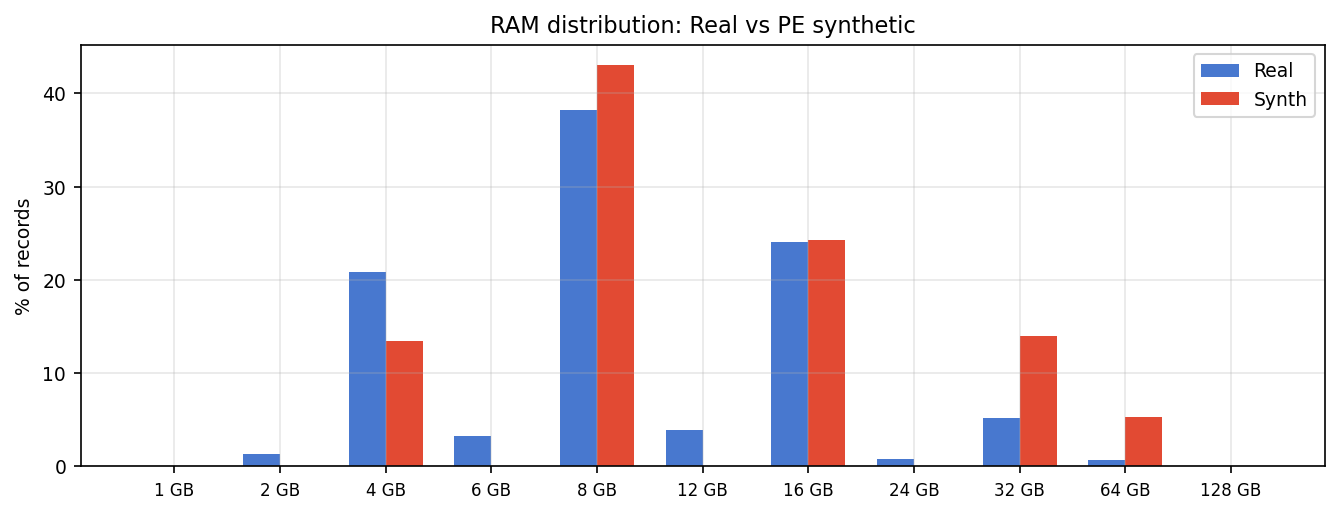

,real_pct,synth_pct
2 GB,1.4,0.0
4 GB,20.9,13.5
6 GB,3.3,0.0
8 GB,38.2,43.0
12 GB,3.9,0.0
16 GB,24.1,24.3
24 GB,0.8,0.0
32 GB,5.2,13.9
64 GB,0.7,5.3
128 GB,0.1,0.0


In [27]:
standard_ram = [1, 2, 4, 6, 8, 12, 16, 24, 32, 64, 128]

real_ram = wide["ram"].value_counts(normalize=True)
synth_ram = chunk["ram"].value_counts(normalize=True)

real_vals = [real_ram.get(r, 0) * 100 for r in standard_ram]
synth_vals = [synth_ram.get(r, 0) * 100 for r in standard_ram]

fig, ax = plt.subplots(figsize=(9, 3.5))
x = np.arange(len(standard_ram))
w = 0.35
ax.bar(x - w / 2, real_vals, w, color=REAL_COLOR, label="Real")
ax.bar(x + w / 2, synth_vals, w, color=SYNTH_COLOR, label="Synth")
ax.set_xticks(x)
ax.set_xticklabels([f"{r} GB" for r in standard_ram], fontsize=8)
ax.set_ylabel("% of records")
ax.set_title("RAM distribution: Real vs PE synthetic")
ax.legend()
plt.tight_layout()
plt.show()

ram_comp = pd.DataFrame({
    "real_pct": [round(v, 1) for v in real_vals],
    "synth_pct": [round(v, 1) for v in synth_vals],
}, index=[f"{r} GB" for r in standard_ram])
display(ram_comp[ram_comp.sum(axis=1) > 0.05])

---
## Cross-column correlations

Check if the LLM preserves key relationships (e.g., Notebook chassis -> lower RAM, certain countries -> certain vendors).

In [28]:
display(Markdown("### Mean RAM by chassis type"))
real_ram_chassis = wide.groupby("chassistype")["ram"].mean().round(1)
synth_ram_chassis = chunk.groupby("chassistype")["ram"].mean().round(1)
ram_chassis = pd.DataFrame({"real": real_ram_chassis, "synth": synth_ram_chassis}).fillna(0)
display(ram_chassis[ram_chassis.sum(axis=1) > 0])

display(Markdown("### Top vendor by country (real vs synth)"))
top_countries = wide["countryname_normalized"].value_counts().head(10).index
real_top = wide.groupby("countryname_normalized")["modelvendor_normalized"].agg(
    lambda x: x.mode().iloc[0] if len(x) > 0 else "")
synth_top = chunk.groupby("countryname_normalized")["modelvendor_normalized"].agg(
    lambda x: x.mode().iloc[0] if len(x) > 0 else "")
vendor_comp = pd.DataFrame({
    "real_top_vendor": real_top.reindex(top_countries),
    "synth_top_vendor": synth_top.reindex(top_countries),
}).dropna()
vendor_comp["match"] = vendor_comp["real_top_vendor"] == vendor_comp["synth_top_vendor"]
display(vendor_comp)
match_rate = vendor_comp["match"].mean() * 100
display(Markdown(f"Top-vendor match rate: {match_rate:.0f}%"))

### Mean RAM by chassis type

,real,synth
chassistype,,
2 in 1,0.0,8.0
Desktop,0.0,10.7
Laptop,0.0,8.0
Notebook,0.0,13.2
Server/WS,0.0,64.0
...,...,...
Workbench,0.0,8.0
Workstation,0.0,28.2
Workstation/Other,0.0,16.0


### Top vendor by country (real vs synth)

,real_top_vendor,synth_top_vendor,match
countryname_normalized,,,
United States of America,Dell,Dell,True
Other,HP,Unknown,False
China,Lenovo,Acer,False
Brazil,Dell,Acer,False
India,HP,Lenovo,False
Germany,Lenovo,HP,False
"Korea, Republic of",Samsung,Gigabyte,False
Russian Federation,Asus,Unknown,False
United Kingdom of Great Britain and Northern Ireland,HP,Dell,False


Top-vendor match rate: 10%

---
## Group co-occurrence

The prompt says each system has data in 1-2 groups. How many groups does each synthetic record actually populate?

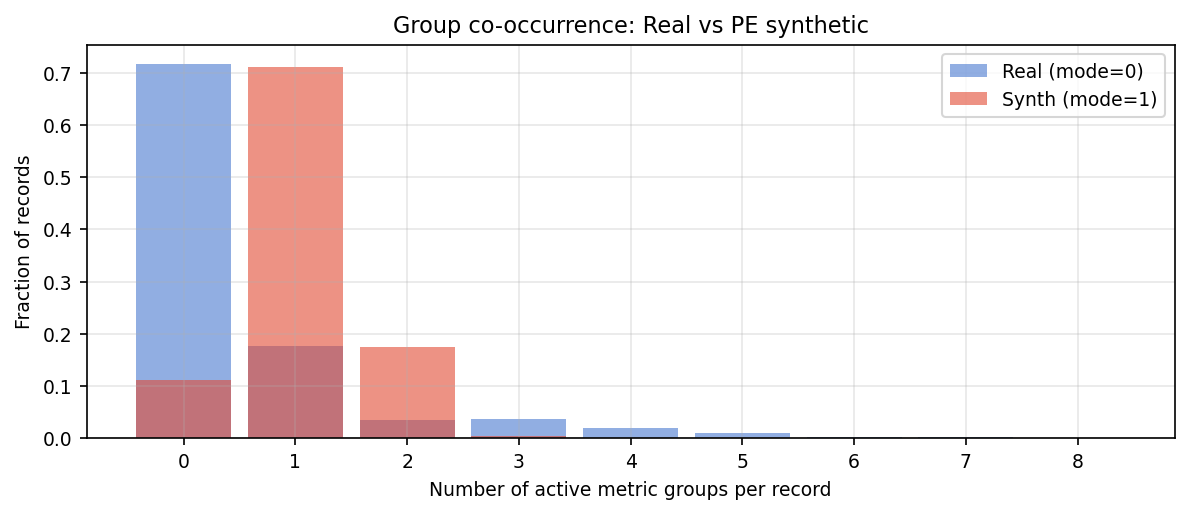

,real_pct,synth_pct
active_groups,,
0,71.8,11.0
1,17.7,71.1
2,3.5,17.5
3,3.7,0.4
4,1.9,0.0
5,1.0,0.0
6,0.3,0.0
7,0.1,0.0
8,0.0,0.0


In [29]:
def count_active_groups(df, groups):
    counts = np.zeros(len(df), dtype=int)
    for gname, cols in groups.items():
        present = [c for c in cols if c in df.columns]
        if present:
            counts += (df[present].abs().sum(axis=1) > 0).astype(int).values
    return counts

real_groups = count_active_groups(wide, groups)
synth_groups = count_active_groups(chunk, groups)

max_g = max(real_groups.max(), synth_groups.max())
bins = np.arange(0, max_g + 2) - 0.5

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.hist(real_groups, bins=bins, density=True, alpha=0.6, color=REAL_COLOR,
        label=f"Real (mode={pd.Series(real_groups).mode().iloc[0]})", rwidth=0.85)
ax.hist(synth_groups, bins=bins, density=True, alpha=0.6, color=SYNTH_COLOR,
        label=f"Synth (mode={pd.Series(synth_groups).mode().iloc[0]})", rwidth=0.85)
ax.set_xticks(range(0, max_g + 1))
ax.set_xlabel("Number of active metric groups per record")
ax.set_ylabel("Fraction of records")
ax.set_title("Group co-occurrence: Real vs PE synthetic")
ax.legend()
plt.tight_layout()
plt.show()

real_gc = pd.Series(real_groups).value_counts(normalize=True).sort_index()
synth_gc = pd.Series(synth_groups).value_counts(normalize=True).sort_index()
gc_comp = pd.DataFrame({
    "real_pct": (real_gc * 100).round(1),
    "synth_pct": (synth_gc * 100).round(1),
}).fillna(0)
gc_comp.index.name = "active_groups"
display(gc_comp)

---
## Summary

In [30]:
cat_overlap_avg = np.mean([r["synth_in_real_pct"] for r in overlap_rows])
sparsity_mae = sparsity_detail["diff"].abs().mean()

display(Markdown(
    f"### Chunk quality summary ({len(chunk):,} records from {len(chunk_files)} chunks)\n\n"
    f"- Categorical overlap (avg % synth values in real vocabulary): {cat_overlap_avg:.1f}%\n"
    f"- Sparsity MAE (avg |diff| in nonzero %): {sparsity_mae:.1f} pp\n"
    f"- Synth group distribution mode: {pd.Series(synth_groups).mode().iloc[0]} active groups "
    f"(real mode: {pd.Series(real_groups).mode().iloc[0]})\n"
    f"- Vendor-country match rate: {match_rate:.0f}%"
))

### Chunk quality summary (79,014 records from 10 chunks)

- Categorical overlap (avg % synth values in real vocabulary): 98.2%
- Sparsity MAE (avg |diff| in nonzero %): 4.8 pp
- Synth group distribution mode: 1 active groups (real mode: 0)
- Vendor-country match rate: 10%